## Project: Garbage Classification
## Team: AI Birds
-----------------------------------------------

### Contributors

1. Ankita
2. Nirupama
3. Piyush
4. Prabhakar Sharma
5. Rohit


### Model Description
-----------------------------------------------

This dataset has 15,150 images from 12 different classes of household garbage; paper, cardboard, biological, metal, plastic, green-glass, brown-glass, white-glass, clothes, shoes, batteries, and trash.

For the current model, we are using only 6 classes due to limitation of hardware configuration. These classes are

***battery, brown-glass, cardboard, paper, plastic, shoes***

Garbage Recycling is a key aspect of preserving our environment. To make the recycling process possible/easier, the garbage must be sorted to groups that have similar recycling process. I found that most available data sets classify garbage into a few classes (2 to 6 classes at most). Having the ability to sort the household garbage into more classes can result in dramatically increasing the percentage of the recycled garbage.

***Source***: Kaggle [https://www.kaggle.com/datasets/mostafaabla/garbage-classification]


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from sklearn.model_selection import train_test_split

import os
import h5py
import random

# Import the necessary libraries
from PIL import Image
import cv2

import tensorflow as tf

from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Add, Activation, ZeroPadding2D, AveragePooling2D

from tensorflow.keras.layers import Flatten, Dense, Dropout, GlobalAveragePooling2D # construct each layer
from tensorflow.keras.layers import Conv2D, BatchNormalization # swipe across the image by 1
from tensorflow.keras.layers import MaxPooling2D, GlobalMaxPooling2D # swipe across by pool size

from tensorflow.keras.applications import ResNet50

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.imagenet_utils import preprocess_input

from tensorflow import keras
import keras.optimizers as optimizers
from keras.utils import to_categorical

%matplotlib inline
import tensorflow.keras.backend as K
# Image dataset has channels as its last dimensions
K.set_image_data_format('channels_last')

In [2]:
# ignore warnings

import warnings
warnings.simplefilter('ignore')

In [3]:
image_base_folder = "garbage-classification-images"

In [4]:
garbage_class_labels = ['battery',                        
                        'brown-glass',
                        'cardboard',
                        'paper',
                        'plastic',
                        'shoes']

In [5]:
# checking files in image dataset folder

print ('Files in folder\n --------------------------------------------\n')

for label in garbage_class_labels:       
    path = image_base_folder + '/' + label;
    print (f'Total files in {label}: {len(os.listdir(path))}')

Files in folder
 --------------------------------------------

Total files in battery: 945
Total files in brown-glass: 607
Total files in cardboard: 891
Total files in paper: 1050
Total files in plastic: 865
Total files in shoes: 1977


In [6]:
def plotImages(root, images_arr):
    
    fig, axes = plt.subplots(1, len(images_arr), figsize=(15, 15))
    axes = axes.flatten()
    
    for ax, image_path in zip(axes, images_arr):
        
        image_file_path = root + "/" + image_path
        
        if os.path.isfile(image_file_path):
            
            img_data = cv2.imread(image_file_path)
            
            img_data = cv2.resize(img_data, (200, 200))
            
            ax.imshow(img_data)
            ax.set_xlabel(image_path)
        else:
            print ("The file " + image_file_path + " does not exist.")
            
    plt.tight_layout()
    plt.show()   

['battery383.jpg', 'battery580.jpg', 'battery282.jpg', 'battery93.jpg']


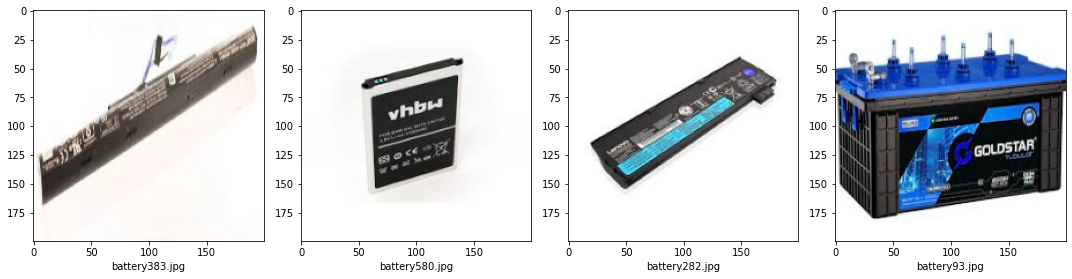

In [7]:
directory = image_base_folder + "/" + "battery"

# Get a list of all the image filenames in the directory
image_filenames = [f for f in os.listdir(directory)]

# Choose 4 random images from the list
chosen_images = random.sample(list(image_filenames), 4)

print (chosen_images)

# display random images

plotImages(directory, chosen_images)

In [8]:
# create an empty dataframe with the correct column names and data types
garbage_df = pd.DataFrame(columns=['image', 'class'])

for index, label in enumerate(garbage_class_labels):
    path = image_base_folder + '/' + label;        
    
    for file in os.listdir(path):
        
        file = path + '/' + file
        
        img_data = cv2.imread(file)
        img_data = cv2.resize(img_data, (120, 120))
        
        img_dict = {'image':list(img_data), 'class': index}
        garbage_df = garbage_df.append(img_dict, ignore_index=True)         

In [9]:
garbage_df['class'].value_counts()

5    1977
3    1050
0     945
2     891
4     865
1     607
Name: class, dtype: int64

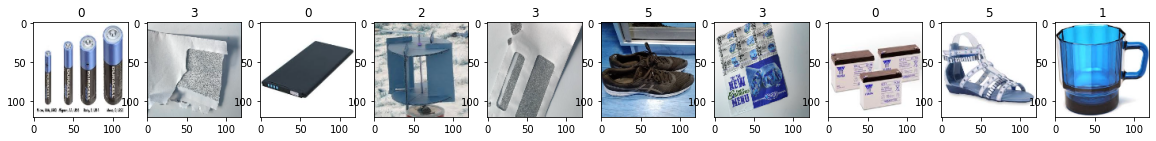

In [10]:
# Visualize the train images

n = 10 # we can increase this value to see more images
df_viz = garbage_df.sample(n) # Taking 'n' random samples from the dataframe 
plt.figure(figsize=(20,20))
for i,j in enumerate(df_viz.iterrows()):
    plt.subplot(1,n,i+1)
    plt.imshow(j[1]['image'])
    plt.title("{}".format(j[1]['class'])) 

In [11]:
# Reshaping image_data suitable for the model
image_data = []

for i, j in enumerate(garbage_df['image']):
    image_data.append(j)

image_data= np.array(image_data, np.float32) # Converting the train data to an array and then normalizing it
image_data.shape

(6335, 120, 120, 3)

In [12]:
# Converting encoded 'class' feature to categorical columns
y = to_categorical(garbage_df['class'], num_classes=None, dtype='int')

print (len(y))

print (y.shape)

6335
(6335, 6)


In [13]:
x_train, x_test, y_train, y_test = train_test_split(image_data, y, test_size=0.2, random_state=2)

In [14]:
print (x_train.shape)
print (x_test.shape)
print(y_train.shape)
print(y_test.shape)

(5068, 120, 120, 3)
(1267, 120, 120, 3)
(5068, 6)
(1267, 6)


In [15]:
# normalize data

x_train = x_train / 255.0
x_test = x_test / 255.0

In [16]:
num_classes = len(garbage_class_labels)

In [17]:
base_model = ResNet50(input_shape=x_train[0].shape,
                      weights='imagenet',
                      include_top=False) #imports the ResNet50 model and discards the last 1000 neuron layer.

In [18]:
x = base_model.output
x = GlobalAveragePooling2D()(x) # Optional
x = Dense(512, activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.
x = Dense(256, activation='relu')(x) #dense layer 2
x = Dense(128, activation='relu')(x) #dense layer 3
x = Dense(128, activation='relu')(x) #dense layer 4
preds = Dense(num_classes, activation='softmax')(x) #final layer with softmax activation

model_resnet50 = Model(inputs = base_model.input, outputs = preds)

In [19]:
# set the first 20 layers of the network to be non-trainable
for layer in model_resnet50.layers[:150]:
    layer.trainable=False
for layer in model_resnet50.layers[150:]:
    layer.trainable=True

### Using SGD optimizer

In [20]:
def plot_model_result(result):
    plt.plot(result.history['accuracy'], label = 'Train')
    plt.plot(result.history['val_accuracy'], label = 'Test')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [21]:
# Compile the model with SGD optimizer and categorical crossentropy loss
sgd = optimizers.SGD(lr=0.01, momentum=0.9)
rms = optimizers.RMSprop()

model_resnet50.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

In [22]:
import time

# Start the timer
start_time = time.time()

In [23]:
# Train the model
sgd_result = model_resnet50.fit(x_train, y_train, epochs=5, batch_size=32, validation_data=(x_test, y_test))

Epoch 1/5
159/159 [==============================] - 252s 2s/step - loss: 1.2551 - accuracy: 0.5274 - val_loss: 1.3161 - val_accuracy: 0.4838
Epoch 2/5
159/159 [==============================] - 262s 2s/step - loss: 1.0610 - accuracy: 0.6129 - val_loss: 1.4413 - val_accuracy: 0.4846
Epoch 3/5
159/159 [==============================] - 272s 2s/step - loss: 0.9626 - accuracy: 0.6545 - val_loss: 1.0216 - val_accuracy: 0.6180
Epoch 4/5
159/159 [==============================] - 275s 2s/step - loss: 0.8954 - accuracy: 0.6800 - val_loss: 1.0295 - val_accuracy: 0.6306
Epoch 5/5
159/159 [==============================] - 275s 2s/step - loss: 0.8435 - accuracy: 0.6938 - val_loss: 1.3953 - val_accuracy: 0.5627


In [24]:
# Calculate the elapsed time
elapsed_time = time.time() - start_time

# Print the elapsed time
print(f"Elapsed time: {elapsed_time} seconds")

Elapsed time: 1335.3715119361877 seconds


In [25]:
sgd_result.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [26]:
model_resnet50.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 120, 120, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 126, 126, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 60, 60, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 60, 60, 64)   256         ['conv1_conv[0][0]']         

 conv2_block3_2_conv (Conv2D)   (None, 30, 30, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 30, 30, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 30, 30, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_3_conv (Conv2D)   (None, 30, 30, 256)  16640       ['conv2_block3_2_relu[0][0]']    
                                                                                                  
 conv2_blo

 conv3_block3_2_conv (Conv2D)   (None, 15, 15, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 15, 15, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 15, 15, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_3_conv (Conv2D)   (None, 15, 15, 512)  66048       ['conv3_block3_2_relu[0][0]']    
                                                                                                  
 conv3_blo

 conv4_block2_2_conv (Conv2D)   (None, 8, 8, 256)    590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 8, 8, 256)   1024        ['conv4_block2_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_2_relu (Activatio  (None, 8, 8, 256)   0           ['conv4_block2_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_3_conv (Conv2D)   (None, 8, 8, 1024)   263168      ['conv4_block2_2_relu[0][0]']    
                                                                                                  
 conv4_blo

 conv4_block5_2_relu (Activatio  (None, 8, 8, 256)   0           ['conv4_block5_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_3_conv (Conv2D)   (None, 8, 8, 1024)   263168      ['conv4_block5_2_relu[0][0]']    
                                                                                                  
 conv4_block5_3_bn (BatchNormal  (None, 8, 8, 1024)  4096        ['conv4_block5_3_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_add (Add)         (None, 8, 8, 1024)   0           ['conv4_block4_out[0][0]',       
                                                                  'conv4_block5_3_bn[0][0]']      
          

 conv5_block2_2_relu (Activatio  (None, 4, 4, 512)   0           ['conv5_block2_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block2_3_conv (Conv2D)   (None, 4, 4, 2048)   1050624     ['conv5_block2_2_relu[0][0]']    
                                                                                                  
 conv5_block2_3_bn (BatchNormal  (None, 4, 4, 2048)  8192        ['conv5_block2_3_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_add (Add)         (None, 4, 4, 2048)   0           ['conv5_block1_out[0][0]',       
                                                                  'conv5_block2_3_bn[0][0]']      
          

### Using Adam optimizer

In [27]:
# Start the timer
start_time = time.time()

In [29]:
# Compile the model with Adam optimizer and categorical crossentropy loss

model_resnet50.compile(optimizer= optimizers.Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

In [30]:
# Train the model
adam_result = model_resnet50.fit(x_train, y_train, epochs=5, batch_size=32, validation_data=(x_test, y_test))

Epoch 1/5
159/159 [==============================] - 259s 2s/step - loss: 0.6661 - accuracy: 0.7668 - val_loss: 0.7716 - val_accuracy: 0.7301
Epoch 2/5
159/159 [==============================] - 273s 2s/step - loss: 0.5840 - accuracy: 0.7964 - val_loss: 0.7611 - val_accuracy: 0.7253
Epoch 3/5
159/159 [==============================] - 280s 2s/step - loss: 0.5447 - accuracy: 0.8102 - val_loss: 0.7242 - val_accuracy: 0.7435
Epoch 4/5
159/159 [==============================] - 282s 2s/step - loss: 0.5123 - accuracy: 0.8214 - val_loss: 0.7503 - val_accuracy: 0.7395
Epoch 5/5
159/159 [==============================] - 288s 2s/step - loss: 0.4832 - accuracy: 0.8293 - val_loss: 0.7180 - val_accuracy: 0.7553


In [31]:
# Calculate the elapsed time
elapsed_time = time.time() - start_time

# Print the elapsed time
print(f"Elapsed time: {elapsed_time} seconds")

Elapsed time: 1557.9906558990479 seconds


In [32]:
model_resnet50.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 120, 120, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 126, 126, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 60, 60, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 60, 60, 64)   256         ['conv1_conv[0][0]']         

 conv2_block3_2_conv (Conv2D)   (None, 30, 30, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 30, 30, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 30, 30, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_3_conv (Conv2D)   (None, 30, 30, 256)  16640       ['conv2_block3_2_relu[0][0]']    
                                                                                                  
 conv2_blo

 conv3_block3_2_conv (Conv2D)   (None, 15, 15, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 15, 15, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 15, 15, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_3_conv (Conv2D)   (None, 15, 15, 512)  66048       ['conv3_block3_2_relu[0][0]']    
                                                                                                  
 conv3_blo

 conv4_block2_2_conv (Conv2D)   (None, 8, 8, 256)    590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 8, 8, 256)   1024        ['conv4_block2_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_2_relu (Activatio  (None, 8, 8, 256)   0           ['conv4_block2_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_3_conv (Conv2D)   (None, 8, 8, 1024)   263168      ['conv4_block2_2_relu[0][0]']    
                                                                                                  
 conv4_blo

 conv4_block5_2_relu (Activatio  (None, 8, 8, 256)   0           ['conv4_block5_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_3_conv (Conv2D)   (None, 8, 8, 1024)   263168      ['conv4_block5_2_relu[0][0]']    
                                                                                                  
 conv4_block5_3_bn (BatchNormal  (None, 8, 8, 1024)  4096        ['conv4_block5_3_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_add (Add)         (None, 8, 8, 1024)   0           ['conv4_block4_out[0][0]',       
                                                                  'conv4_block5_3_bn[0][0]']      
          

 conv5_block2_2_relu (Activatio  (None, 4, 4, 512)   0           ['conv5_block2_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block2_3_conv (Conv2D)   (None, 4, 4, 2048)   1050624     ['conv5_block2_2_relu[0][0]']    
                                                                                                  
 conv5_block2_3_bn (BatchNormal  (None, 4, 4, 2048)  8192        ['conv5_block2_3_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_add (Add)         (None, 4, 4, 2048)   0           ['conv5_block1_out[0][0]',       
                                                                  'conv5_block2_3_bn[0][0]']      
          

### Display result

SGD Optimizer result
---------------------------------------------------------


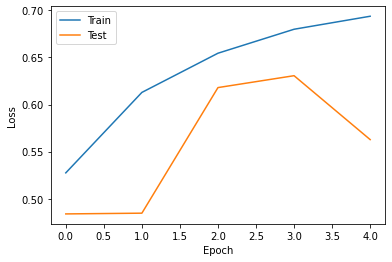

In [33]:
print ('SGD Optimizer result')
print ('---------------------------------------------------------')
plot_model_result(sgd_result)

Adam Optimizer result
---------------------------------------------------------


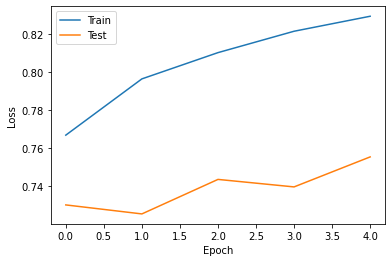

In [34]:
print ('Adam Optimizer result')
print ('---------------------------------------------------------')
plot_model_result(adam_result)

### Creating pickle model

In [70]:
import pickle

In [71]:
pickle.dump(model_resnet50, open('garbage_classification_model_pickle.pkl', "wb"))

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers\activation
......vars
...layers\activation_1
......vars
...layers\activation_10
......vars
...layers\activation_11
......vars
...layers\activation_12
......vars
...layers\activation_13
......vars
...layers\activation_14
......vars
...layers\activation_15
......vars
...layers\activation_16
......vars
...layers\activation_17
......vars
...layers\activation_18
......vars
...layers\activation_19
......vars
...layers\activation_2
......vars
...layers\activation_20
......vars
...layers\activation_21
......vars
...layers\activation_22
......vars
...layers\activation_23
......vars
...layers\activation_24
......vars
...layers\activation_25
......vars
...layers\activation_26
......vars
...layers\activation_27
......vars
...layers\activation_28
......vars
...layers\activation_29
......vars
...layers\activation_3
......vars
...layers\activation_30
......vars
...layers\activation_31
......vars
...layers\activation_32
......

Keras model archive saving:
File Name                                             Modified             Size
config.json                                    2023-03-26 17:15:26        87608
metadata.json                                  2023-03-26 17:15:26           64
variables.h5                                   2023-03-26 17:15:28     99740752


### Testing code

In [37]:
from tensorflow.keras.preprocessing import image

In [38]:
# Load the pre-trained ResNet50 model
with open('garbage_classification_model_pickle.pkl', 'rb') as f:
    model = pickle.load(f)

testing_folder_path = "testing_images"

Keras model archive loading:
File Name                                             Modified             Size
config.json                                    2023-03-26 16:35:20        87608
metadata.json                                  2023-03-26 16:35:20           64
variables.h5                                   2023-03-26 16:35:20     99740752
Keras weights file (<HDF5 file "variables.h5" (mode r)>) loading:
...layers\activation
......vars
...layers\activation_1
......vars
...layers\activation_10
......vars
...layers\activation_11
......vars
...layers\activation_12
......vars
...layers\activation_13
......vars
...layers\activation_14
......vars
...layers\activation_15
......vars
...layers\activation_16
......vars
...layers\activation_17
......vars
...layers\activation_18
......vars
...layers\activation_19
......vars
...layers\activation_2
......vars
...layers\activation_20
......vars
...layers\activation_21
......vars
...layers\activation_22
......vars
...layers\activation_23
......

...layers\conv2d_6
......vars
.........0
.........1
...layers\conv2d_7
......vars
.........0
.........1
...layers\conv2d_8
......vars
.........0
.........1
...layers\conv2d_9
......vars
.........0
.........1
...layers\dense
......vars
.........0
.........1
...layers\dense_1
......vars
.........0
.........1
...layers\dense_2
......vars
.........0
.........1
...layers\dense_3
......vars
.........0
.........1
...layers\dense_4
......vars
.........0
.........1
...layers\global_average_pooling2d
......vars
...layers\input_layer
......vars
...layers\max_pooling2d
......vars
...layers\zero_padding2d
......vars
...layers\zero_padding2d_1
......vars
...metrics\mean
......vars
.........0
.........1
...metrics\mean_metric_wrapper
......vars
.........0
.........1
...vars


***testing of single image***

In [52]:
def display_prediction(prediction_array):
    highest_pred = max(preds[0])
    index_highest_pred = list(preds[0]).index(highest_pred)
    image_class = garbage_class_labels[index_highest_pred]
    
    print ('File Name: ', file)
    print ('Class: ', image_class)
    print ('Accuracy: ', highest_pred)

In [66]:
file = os.listdir(testing_folder_path)[2]

file = testing_folder_path + "/" + file

file

'testing_images/cardboard11.jpg'

1/1 [==============================] - 0s 74ms/step


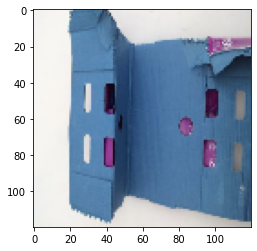

In [67]:
img_data = cv2.imread(file)
img_data = cv2.resize(img_data, (120, 120))

plt.imshow(img_data)
img = image.load_img(file, target_size=(120, 120))

img = np.array(img) / 255.0

# Preprocess the image for input to the model
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

# Use the model to make a prediction on the image
preds = model.predict(x)

In [69]:
preds

array([[0.03426154, 0.0013397 , 0.00144817, 0.9581574 , 0.0016919 ,
        0.00310127]], dtype=float32)

In [68]:
display_prediction(preds)

File Name:  testing_images/cardboard11.jpg
Class:  paper
Accuracy:  0.9581574
